In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

lidar_import = np.load('data/lidar_data.npz')
intensity = lidar_import['intensity']
dem = lidar_import['dem']
dsm = lidar_import['dsm']
shadow = lidar_import['shadow']

### Lidar Data Overview ###

Several lidar derivatives have previously been generated and are loaded above. These include:

* Intensity Raster: grayscale image derived from the pixel-wise average magnitude of lidar intensity returned.
* Bare Earth DEM: surface model of topography derived from lidar points previously classified as terrain
* First Return DSM: surface model of the highest lidar point per pixel
* Estimated Shadow Raster: locations of expected shadows at time of image collection; built from lidar DSM

Several pre-processing steps were applied to the lidar data to generate these data sets. Notable, the cars in the parking lot were excluded from the shadow map generation, as the variance in refelectance present in those regions were not conducive to this experiment.

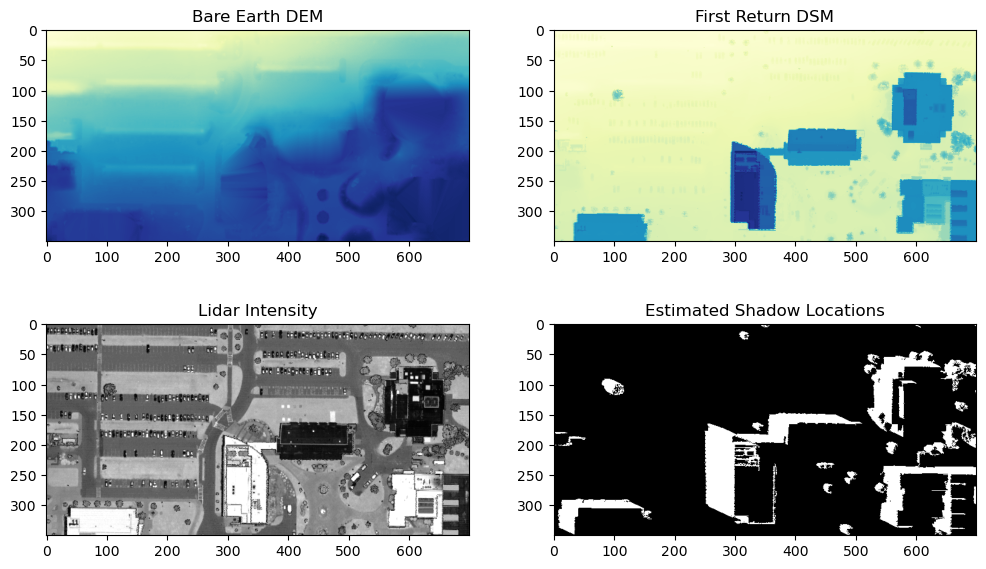

In [2]:
plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(dem, cmap='YlGnBu')
plt.title('Bare Earth DEM')


plt.subplot(222)
plt.imshow(dsm, cmap='YlGnBu')
plt.title('First Return DSM')

plt.subplot(223)
plt.imshow(intensity, cmap='gray')
plt.title('Lidar Intensity')

plt.subplot(224)
plt.imshow(shadow, cmap='gray')
plt.title('Estimated Shadow Locations')

plt.show()

### Initial Segmentation ###

We want to use the lidar data to identify regions which are likely homogenous surfaces. As lidar is an active form of remote sensing, intensity values tend to be very similar for returns coming from surfaces of a similar material and orientation. Using an unsupervised classification method suchh as k-Means clustering we can identify candidate regions for analysis. Later stages will identify distinct regions, so the number of initial clusters used in this step can be relatively small ($<10$).

Our focus is processing hyperspectral imagery at the ground level that has been obscured by shadows. We can threshold a normalized DSM to generate a mask that removes the tops of trees, cars, and buildings from our results.

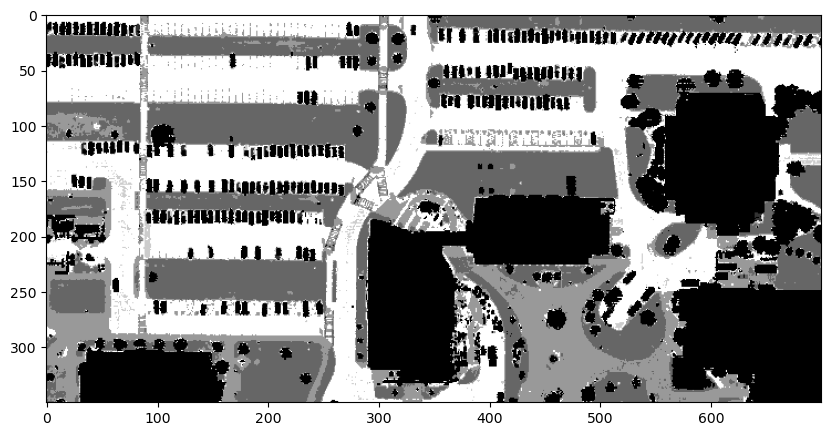

In [3]:
intensity_matrix = np.float32(intensity.reshape(intensity.shape[0] * intensity.shape[1]))
crit = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

val, segments, centers = cv.kmeans(intensity_matrix, 6, None, crit, 10, cv.KMEANS_RANDOM_CENTERS)
segments = segments.reshape(intensity.shape)

ndsm = dsm - dem
ndsm_mask = ndsm < 0.35    # height threshold in meters

plt.figure(figsize=(10,10))
plt.imshow(segments * ndsm_mask, cmap='gray')
plt.show()


In [4]:
def erode_segmented_image( boolean_image, mask, kernel_size ):
        
    erosion_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    eroded_img = cv.erode(np.uint8(boolean_image), erosion_kernel)
    return eroded_img * mask


In [5]:
def distinct_segment_regions( segment_map, min_area_in_pixels ):
    
    num_features, features, stats, centroids = cv.connectedComponentsWithStats(segment_map)
    connected_regions_to_use = {}
    current_idx = 0

    # identify connected regions with an area > minimum specified, and store a new region label
    # in dictionar for use in output (new labels are 0-based, sequential, only for features kept)

    for feature_label in range(1, num_features):
        if stats[feature_label, 4] >= min_area_in_pixels:
            connected_regions_to_use[feature_label] = current_idx
            current_idx += 1

    output_map = np.zeros(features.shape)
    for r in range(output_map.shape[0]):
        for c in range(output_map.shape[1]):
            if features[r,c] in connected_regions_to_use:
                output_map[r,c] = connected_regions_to_use[features[r,c]]

    return output_map

In [6]:
def split_regions_by_shadow( region_map, shadow_map ):
    
    regions_in_shadow = region_map * shadow_map
    region_id_with_shadows = set(np.unique(regions_in_shadow))

    not_shadow_map = 1 - shadow_map
    regions_not_in_shadow = region_map * not_shadow_map
    region_id_without_shadows = set(np.unique(regions_not_in_shadow))

    usable_region_ids = region_id_with_shadows.intersection(region_id_without_shadows)

    regions_in_shadow = np.zeros_like(region_map)
    regions_not_in_shadow = np.zeros_like(region_map)

    for region in usable_region_ids:
        regions_in_shadow[region_map == region] = region
        regions_not_in_shadow[region_map == region] = region

    return (regions_in_shadow * shadow_map, regions_not_in_shadow * not_shadow_map)
    

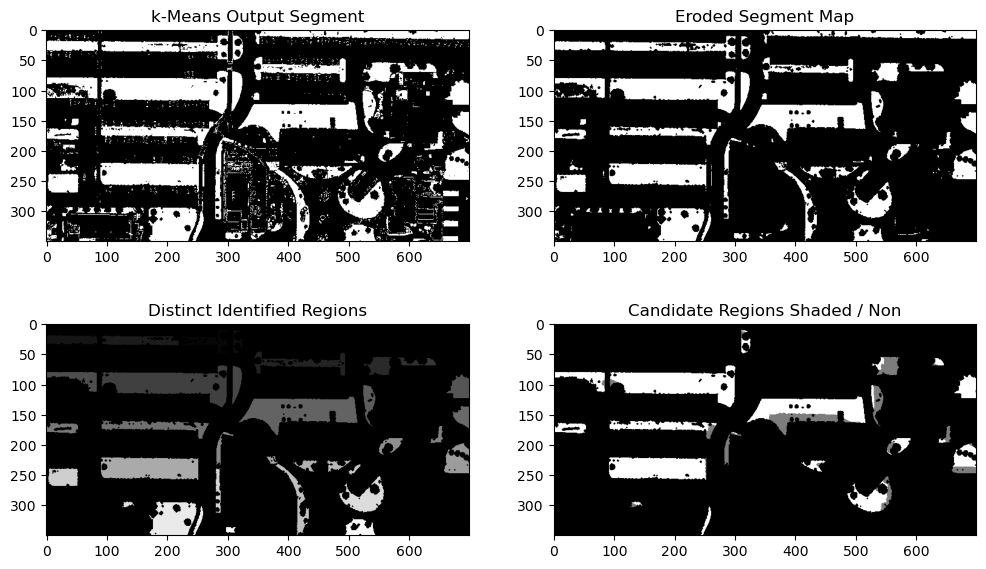

In [7]:
example_segment = segments[100,200]     # obtain segment label associated with one grass pixel for example plots
kernel_size = 3

eroded_segment_image = erode_segmented_image(segments==example_segment, ndsm_mask, kernel_size)
distinct_regions = distinct_segment_regions( eroded_segment_image, 85 )     # note : 1px == 1 sq meter

plt.figure(figsize=(12,7))

plt.subplot(221)
plt.imshow(segments==example_segment, cmap='gray')
plt.title('k-Means Output Segment')

plt.subplot(222)
plt.imshow(eroded_segment_image, cmap='gray')
plt.title('Eroded Segment Map')

plt.subplot(223)
plt.imshow(distinct_regions, cmap='gray')
plt.title('Distinct Identified Regions')

patches_in_shade, patches_not_in_shade = split_regions_by_shadow(distinct_regions, shadow)
split_patches = np.zeros_like(distinct_regions)
split_patches[patches_in_shade > 0] = 125
split_patches[patches_not_in_shade > 0] = 255

plt.subplot(224)
plt.imshow(split_patches, cmap='gray')
plt.title('Candidate Regions Shaded / Non')

plt.show()